In [6]:
#%matplotlib inline
import numpy as np
#import pandas as pd
import matplotlib.pyplot as plt
from qutip import *
from tqdm import tqdm
from numpy import sin, cos, sqrt, array, linspace

### Tripartite system: $H_{hyb}$

Fig 2b
Fig 1b

### Hamiltonian For this fully coupled syestem:
\begin{equation} \label{eq:Heff_c2} 
\Large \hat{H}_{Hyb}=\omega_{c}\hat{a}^\dagger \hat{a}+ \frac{\omega_{a}}{2}\hat{\sigma}_{z}+\omega_m \hat{b}^\dagger \hat{b} \\
\Large \;\;\;\;\;\;\;\;\;\;\; ig_{ac}(\hat{\sigma}_{+}\hat{a}-\hat{\sigma}_{-}\hat{a}^\dagger) -
 g_{cm}\hat{a}^\dagger \hat{a}(\hat{b}+\hat{b}^\dagger) -
 g_{am} \hat{\sigma}_{z}(\hat{b}+\hat{b}^\dagger)
\end{equation}

In [7]:
# a function to define H_0 and <n>
def mean_steady(w_m, w_L, Delta_aL, w_cLlist, g_cm, g_am, g_ac, n_th, kappa, gamma, F_L):
    N = 5 #5                  # number of cavity fock states
    M = 9 #10                 # number of phonon fock states   
   
    a = tensor(destroy(N), qeye(M), qeye(2))
    b = tensor(qeye(N), destroy(M), qeye(2))
    sigma_z = tensor(qeye(N), qeye(M), sigmaz())
    sigma_p = tensor(qeye(N), qeye(M), sigmap())  # raising and lowering ops for atom
    sigma_m = tensor(qeye(N), qeye(M), sigmam())
    
    num_a = a.dag() * a 
    num_b = b.dag() * b  

    c_ops = []
    gamma_a = gamma                           # decay rate of Atom
    rate = kappa                              # kappa is cavity decay rate
    if rate > 0.0 : 
        c_ops.append(a * sqrt(rate))
    rate = n_th * gamma                       # gamma is decay for mechanical resonator 
    if rate > 0.0: 
        c_ops.append(b.dag() * sqrt(rate))
    rate = (n_th+1) * gamma
    if rate > 0.0 : 
        c_ops.append(b * sqrt(rate))
    rate = gamma_a
    if rate > 0.0 : 
        c_ops.append(sigma_m * sqrt(rate))
    idx = 0 
    n   = np.zeros(shape(w_cLlist)) 
    #n   = np.zeros(shape(delta_list))
    ######
    for w_c in w_cLlist:  
        
        H_Cav  = -(w_L - w_c) * num_a             #
        H_Atm  =  0.5 * (Delta_aL) *sigma_z             # 
        H_Mech =  w_m * num_b                          #
        #### Interaction  Hamiltonian
        H_Int  = 1j * g_ac *(sigma_p * a - sigma_m * a.dag())- g_cm* num_a *(b.dag() + b)- g_am *(sigma_z + 1) * (b.dag() + b) 
        # Laser drive 
        H_drive   =  1j* F_L *(a.dag()-a)   
        ##### Total H: 
        H =  H_Cav + H_Atm + H_Mech + H_Int + H_drive #+ H_0
        # at resonance and for g_eff=0

        solvers = ['direct','power','eigen','iterative-gmres','iterative-bicgstab']  # methods 
        ## only for ['iterative-gmres','iterative-bicgstab']---  use_rcm = True
        use_rcm = False
        rho = steadystate(H, c_ops, method=solvers[2], tol=1e-15) # ,use_rcm=use_rcm ,use_precond=True,
        n[idx] = expect(a.dag()*a,rho)

        idx +=1
        
    H_Atm1  = 0.5 * (Delta_aL) *sigma_z
    H0      = H_Atm1 + w_m * num_b  + H_drive
    return  n, c_ops, a, H0

### Parameters 

In [8]:
Set = 3               ##### set of Parametrs    

if (Set==1):
    w_a  = 105      #[ 1500 ]   [1052  ]
    w_L  =  100 
    g_am = 0.5         #[  50   ]  [.54    ] 
    g_ac =  5   
elif Set==2:
    w_a  = 10520      #[ 15000 ]  [10520  ]
    w_L =  10000 
    g_am = 0.54      #[  50   ]   [.54     ]
    g_ac =  500
elif Set==3: 
    w_a  = 15000      #[ 15000 ]  [10520  ]
    w_L =  10000 
    g_am = 50      #[  50   ]   [.54     ]
    g_ac =  500   

w_m  = 1                       # mechanical frequency
n_th_i   = [0, 0, 1, 0 ]
gamma    = w_m/20.                                ## gamma is decay for mechanical resonator 
kappa_i  = [w_m/2., 2. * w_m, w_m/2., w_m/2.]     # kappa is cavity decay rate
g_cm = 0.001 * w_m               # cavity-resonator couplng  10 ^-5
Delta_aL = w_a - w_L
shift = g_ac**2/Delta_aL
shift

50.0

In [9]:
Delta_aL = w_a - w_L
w_c  = w_L +(g_ac**2)/Delta_aL

alpha = g_am * (1-(g_ac/Delta_aL)**2) 
shift = g_ac**2/Delta_aL
g_eff = g_cm + 2 * g_am * (g_ac/Delta_aL)**2
g_eff
#alpha
shift


50.0

## Display Figures 

100%|██████████| 4/4 [05:31<00:00, 82.82s/it]


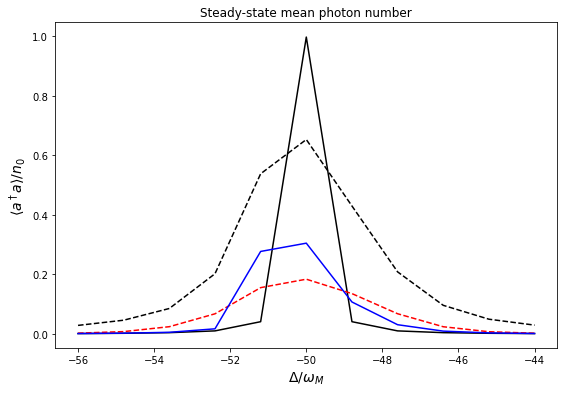

In [10]:
tlist = np.linspace(0, 100.0, 1000)        # Time evolution
fig, ax= plt.subplots(1,1,figsize=(9,6))
linestyle =['-','--','--','-']
color=['black', 'black', 'r', 'b']


Delta_aL = w_a - w_L
g_am_i = [0, g_am, g_am, g_am]
minn_c = w_L + shift + 6  #    w_L + 490
maxx_c = w_L + shift -6   #    w_L + 470

w_cLlist = np.linspace((minn_c )* w_m, (maxx_c ) * w_m, 11)  # so \Delta change between [-465, -495]     
#### to save data
xplot = []                                 #######=====###########====####
pllot2b  = np.zeros((len(w_cLlist),4))       ############tlist
#pllot4aa  = np.zeros((len(w_cLlist),4))       ############wlist

for i in tqdm([0, 1, 2, 3 ]): #[0, 1, 2, 3]:
    g_am  = g_am_i[i]
    shift = g_ac**2/Delta_aL
    kappa = kappa_i[i]
    n_th  = n_th_i[i]
    F_L   = sqrt(kappa) * 0.01        #   Laser amplitude        
    n, c_ops, a, H0 = mean_steady(w_m, w_L , Delta_aL, w_cLlist, g_cm, g_am, g_ac, n_th, kappa, gamma, F_L)    

    solvers = ['direct','power','eigen','iterative-gmres','iterative-bicgstab']  # methods 
    # only for ['iterative-gmres','iterative-bicgstab']---  use_rcm = True
    use_rcm = False        
    #  <n_0>
    #rho0 = steadystate(H0, c_ops, method=solvers[2], tol=1e-14)  ### to
    #n_0 = expect(a.dag()*a,rho0) 
    n_0 = 4 * (F_L/kappa)**2        # alternative way for n_0
    
    ax.plot(w_L - w_cLlist , n/n_0, linestyle =linestyle[i], color=color[i])
    
    xplot = w_L - w_cLlist
    pllot2b[: , i] = n/n_0
        
ax.set_xlabel(r'$\Delta/ \omega_M $', fontsize=14)
ax.set_ylabel(r'$\langle a^ \dagger a  \rangle /n_0 $', fontsize=14)    # (r'$ e $',fontsize=16,color='red')
ax.set_title('Steady-state mean photon number')
#######        
plt.savefig("SteaSt_Mean_Hyb_NoDis_Modi_15000.pdf") # , dpi=50   #####1b
plt.show()

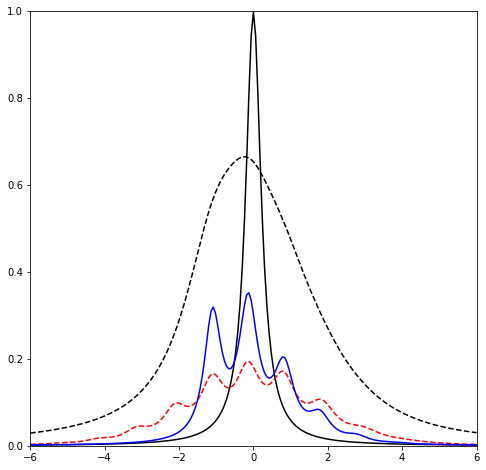

In [26]:

data1b = np.column_stack([xplot, pllot2b[: , 0],pllot2b[: , 1] ,pllot2b[: , 2], pllot2b[: , 3]])
np.savetxt("Fig1b15000Modf_SS.txt" , data1b, fmt=['%s','%s','%s','%s','%s'])

linestyle =['-.','-','--','--','-']
color=['t','black', 'black', 'r', 'b']
fig, ax= plt.subplots(1,1,figsize=(8,8))
for i in [1,2,3,4]:
    plt.plot(xplot, data1b[:,i], linestyle = linestyle[i], color = color[i])
    
ax.set_xlim([-6,6])
ax.set_ylim([0,1])
plt.savefig("SteaSt_MeanPhoton_Modi_1b_15000.pdf", dpi=150)
plt.show()
